# Prova Final de Business Analytics

Nícolas Mikio Isiki

<p>
   Realizei a prova de Business Analytics em Python. <br />
   Tratei a base de dados e fiz a modelagem utilizando técnicas de random over-sampling para balanceamento de base e a feature XGBoost para treinamento do modelo
</p>

## Importar os Dados e Análises Iniciais

In [1]:
import pandas as pd
import researchpy as rp
import datetime
from datetime import date
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from matplotlib import pyplot
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import operator
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as pl

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel('blu365.xlsx')

In [3]:
display(df)
df.columns

,datadisparo,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo
0,2020-05-19,62,0,0,0,0,0,2019-05-24,126.21,Claro,0,NaT,NaT,0,22.0,M,H,H,H,NaN,0,0
1,2020-04-27,67,3,0,0,0,0,2017-04-14,244.29,Vivo,0,NaT,NaT,3,56.0,F,D,H,D,ATE 2 SM,0,0
2,2020-05-14,51,1,0,0,0,0,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0
3,2020-05-13,51,0,0,0,0,0,2019-11-14,307.91,Tim,0,NaT,NaT,0,35.0,F,B,H,B,4 A 10 SM,0,0
4,2020-05-25,62,0,0,12,0,0,2017-03-14,154.12,Tim,0,NaT,NaT,12,43.0,F,A,H,A,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686378,2020-05-21,51,0,0,0,0,0,2017-03-27,215.34,Tim,0,NaT,NaT,0,68.0,M,G,H,G,NaN,0,0
686379,2020-05-07,61,0,0,5,0,0,2018-06-14,62.59,Claro,0,NaT,NaT,5,20.0,F,F,H,F,ATE 2 SM,0,0
686380,2020-05-18,41,4,0,0,0,0,2019-11-14,430.02,Tim,0,NaT,NaT,4,54.0,F,A,H,A,ATE 2 SM,0,0
686381,2020-05-13,41,0,0,0,0,0,2019-12-14,278.78,Tim,0,NaT,NaT,0,39.0,F,B,H,B,ATE 2 SM,0,0


Index(['datadisparo', 'ddd', 'sms_entregue', 'sms_enviado', 'sms_naoentregue',
       'sms_rejeitado', 'sms_invalido', 'data_atraso', 'valor', 'operadora',
       'qtd_hist_acessos', 'data_maisrecente_acesso', 'data_maisantiga_acesso',
       'sms_total_tent', 'idade', 'genero', 'compradoronline',
       'vendedoronline', 'utilizacaoweb', 'rendaestimada', 'acesso', 'acordo'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686383 entries, 0 to 686382
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datadisparo              686383 non-null  datetime64[ns]
 1   ddd                      686383 non-null  int64         
 2   sms_entregue             686383 non-null  int64         
 3   sms_enviado              686383 non-null  int64         
 4   sms_naoentregue          686383 non-null  int64         
 5   sms_rejeitado            686383 non-null  int64         
 6   sms_invalido             686383 non-null  int64         
 7   data_atraso              686383 non-null  datetime64[ns]
 8   valor                    686383 non-null  float64       
 9   operadora                686383 non-null  object        
 10  qtd_hist_acessos         686383 non-null  int64         
 11  data_maisrecente_acesso  77512 non-null   datetime64[ns]
 12  data_maisantiga_

operadora, genero, compradoronline, vendedoronline, utilizacaoweb, rendaestimada são objetos. Provavelmente possuem valores NAN
ou mesmo inconsistências nos dados

## Data Engeneering

In [5]:
#criar coluna de identificação
df["id"] = df.index

#retirar 'datadisparo', pois é uma variáveis qualitativa nominal realcionado ao momento da execução operacional do envio do sms
df = df.drop(columns=['datadisparo'])

In [6]:
print("número de pessoas que não enviaram o sms:", 
len(df[(df['sms_entregue']==0) & (df['sms_enviado']==0) & (df['sms_naoentregue']==0) & (df['sms_rejeitado']==0) & (df['sms_invalido']==0)]))

número de pessoas que não enviaram o sms: 218437


In [7]:
print("número de pessoas que não receberam o sms:", 
len(df[(df['sms_entregue']==0) & (df['sms_enviado']==0) & ((df['sms_naoentregue']==1) | (df['sms_rejeitado']==1) | (df['sms_invalido']==1))]))

número de pessoas que não receberam o sms: 36419


In [8]:
print("número de pessoas que recebram o sms:", 
len(df[((df['sms_entregue']==1) | (df['sms_enviado']==1)) & (df['sms_naoentregue']==0) & (df['sms_rejeitado']==0) & (df['sms_invalido']==0)]))

número de pessoas que recebram o sms: 74265


Como o estudo se trata de calcular a probabilidade de acesso e acordo após um disparo, então só devemos considerar
casos em que foi efetivamente realizado o disparo e o cliente recebeu o sms. Logo reduziremos a base para incluir somentes
as linhas identificadas nessa parte do estudo

In [9]:
def f(row):
    if row['sms_entregue'] == 1:
        val = 1
    elif row['sms_enviado'] == 1:
        val = 1
    else:
        val = 0
    return val

df["RecebeuSMS"] = df.apply(f, axis=1)

df = df[df["RecebeuSMS"]==1]

In [10]:
df

,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,1,0,0,0,0,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,1,0,0,0,0,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,1,0,0,0,0,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,1,0,0,0,0,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,1,0,0,0,0,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,1,0,0,0,0,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,1,0,0,0,0,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,1,0,0,0,0,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,1,0,0,0,0,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


Observa-se que há inconsistências no número de pessoas que receberam o SMS calculado pelo método anterior, com o resultado de
número de linhas na tabela. Realizamos mais um procedimento para tratemento da base

In [11]:
df = df[df["sms_naoentregue"]==0]
df = df[df["sms_rejeitado"]==0]
df = df[df["sms_invalido"]==0]

In [12]:
df

,ddd,sms_entregue,sms_enviado,sms_naoentregue,sms_rejeitado,sms_invalido,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,1,0,0,0,0,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,1,0,0,0,0,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,1,0,0,0,0,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,1,0,0,0,0,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,1,0,0,0,0,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,1,0,0,0,0,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,1,0,0,0,0,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,1,0,0,0,0,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,1,0,0,0,0,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


In [13]:
count_no_acordo = len(df[df['acordo']==0])
count_acordo = len(df[df['acordo']==1])

print ("a quantidade de clintes que NÃO acordaram é ", count_no_acordo)
print ("a quantidade de clintes que acordaram é", count_acordo)


pct_acordo = count_no_acordo/(count_no_acordo+count_acordo)
print("% que acordou dos clientes que acessaram é ", pct_acordo*100)

a quantidade de clintes que NÃO acordaram é  73851
a quantidade de clintes que acordaram é 414
% que acordou dos clientes que acessaram é  99.44253686124014


In [14]:
#Todos os clientes que acordaram também acessaram? (Verficar se há inconsistências na base)
len(df[(df['acesso']==1) & (df['acordo']==1)])

414

Validado. Resultado é semelhante a quantidade de clientes que acordaram (independente do acesso)

In [15]:
count_no = len(df[df['acesso']==0])
count = len(df[df['acesso']==1])

print ("a quantidade de clintes que NÃO acessaram é ", count_no)
print ("a quantidade de clintes que acessaram é", count)


pct = count_no/(count_no+count)
print("% da base que acessou é ", pct*100)

a quantidade de clintes que NÃO acessaram é  71257
a quantidade de clintes que acessaram é 3008
% da base que acessou é  95.94963980340671


In [16]:
#Remover variáveis que foram utilizadas para criar a variável 'RecebeuSMS'
df = df.drop(columns = ['sms_entregue', 'sms_enviado', 'sms_naoentregue', 'sms_rejeitado', 'sms_invalido'])

In [17]:
for i in df.columns:
    print(df['%s' %(i)].value_counts())
    print('')

41    10077
61     8475
62     7968
51     7133
67     5186
      ...  
74        5
33        5
37        4
97        3
28        2
Name: ddd, Length: 67, dtype: int64

2019-11-14    2921
2019-12-14    2753
2019-10-15    2497
2019-09-14    1957
2019-08-15    1840
              ... 
2012-03-30       1
2014-07-12       1
2015-08-20       1
2017-02-16       1
2016-11-18       1
Name: data_atraso, Length: 2566, dtype: int64

49.96     707
34.90     362
74.94     183
24.98     161
69.80     122
         ... 
18.43       1
574.63      1
488.73      1
40.45       1
464.22      1
Name: valor, Length: 42543, dtype: int64

Tim       21882
Claro     21240
Vivo      18103
Oi        12824
Outros      172
Nextel       44
Name: operadora, dtype: int64

0    69054
1     4726
2      418
3       51
4       10
5        5
8        1
Name: qtd_hist_acessos, dtype: int64

2020-05-04    878
2020-05-13    566
2020-05-20    432
2020-05-19    281
2020-04-27    265
2020-05-12    239
2020-05-14    199
2020-05-18 

In [18]:
for i in df.columns:
    print(df['%s' %(i)].value_counts().sort_index())
    print('')

11    331
12     19
13     38
14     44
15     26
     ... 
95      9
96      5
97      3
98     30
99     41
Name: ddd, Length: 67, dtype: int64

1993-11-12     1
1996-05-02     1
1996-06-16     1
1996-08-12     1
1996-08-14     1
              ..
2020-02-03     4
2020-02-04    61
2020-02-05     4
2020-02-06    46
2020-02-08     1
Name: data_atraso, Length: 2566, dtype: int64

5.30        1
10.00       8
10.01       2
10.02       5
10.03       6
           ..
7421.82     1
7807.21     1
8098.41     1
9317.30     1
23701.01    1
Name: valor, Length: 42543, dtype: int64

Claro     21240
Nextel       44
Oi        12824
Outros      172
Tim       21882
Vivo      18103
Name: operadora, dtype: int64

0    69054
1     4726
2      418
3       51
4       10
5        5
8        1
Name: qtd_hist_acessos, dtype: int64

2020-04-03      3
2020-04-07      2
2020-04-11      1
2020-04-13      1
2020-04-14     74
2020-04-15     14
2020-04-16     46
2020-04-17    109
2020-04-18     37
2020-04-19     15
2

## Retirar valores incondizentes na idade

In [19]:
df

,ddd,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


In [20]:
#Adotamos uma estratégia de range de idades entre 18 a 95 anos (pessoa mais velha no Brasil tem 115 anos)
df = df[((df['idade'] >= 18) & (df['idade'] <= 95))]

print(df['idade'].value_counts().sort_index())
print("")
print("-------------------------------------------------------------")
print("")
p = df[(df.idade < 18) & (df.idade != 0)]
print(p['idade'].value_counts().sort_index())

18.0      11
19.0     558
20.0    1126
21.0    1293
22.0    1528
        ... 
91.0      61
92.0      52
93.0      55
94.0      39
95.0      29
Name: idade, Length: 78, dtype: int64

-------------------------------------------------------------

Series([], Name: idade, dtype: int64)


In [21]:
df

,ddd,data_atraso,valor,operadora,qtd_hist_acessos,data_maisrecente_acesso,data_maisantiga_acesso,sms_total_tent,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,2019-09-04,51.00,Claro,0,NaT,NaT,1,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,2017-02-27,57.17,Oi,0,NaT,NaT,1,77.0,F,G,H,G,NaN,0,0,21,1
30,63,2018-12-14,321.22,Oi,0,NaT,NaT,1,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,2019-12-14,14.05,Claro,0,NaT,NaT,1,57.0,M,E,H,E,NaN,0,0,33,1
44,42,2019-12-19,428.00,Tim,0,NaT,NaT,1,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,2017-08-24,542.27,Tim,0,NaT,NaT,1,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,2019-12-10,498.97,Claro,0,NaT,NaT,1,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,2015-10-09,186.98,Claro,0,NaT,NaT,1,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,2019-11-28,425.97,Oi,0,NaT,NaT,1,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


## Retirar coluna 'sms_total_tent'

In [22]:
df = df.drop(columns=['sms_total_tent'])

## Tratando missing values

In [23]:
for i in df.columns:
    if df['%s' %(i)].isnull().sum() != 0:
        print (i)
        print (df['%s' %(i)].isnull().sum())
        print ("")

data_maisrecente_acesso
68698

data_maisantiga_acesso
68698

rendaestimada
19225



Como verificado, não sabemos a informação da maioria das datas de acesso, resolvemos retirar essas colunas. Sobre a renda estimada, temos uma proporção menor de casos missing, então resolvemos utilizar a média do valor da coluna para resolver esse problema. A escolha da solução foi baseada na interpretação de que a variáriável pode ter uma grande utilidade para explicação do problema, então não queremos descartá-la (excluí-la), muito menos não poderíamos apagar as linhas da base devido pois descartaríamos informações relevantes.

In [24]:
df = df.drop(columns=['data_maisrecente_acesso','data_maisantiga_acesso'])

In [25]:
df = df.fillna(df.mean())

<ipython-input-25-04e87d67d337>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.mean())


## Estudo das variáveis qualitativas

In [26]:
dfteste = df.drop(columns=['idade', 'data_atraso', 'valor', 'qtd_hist_acessos'])

In [27]:
for i in dfteste.columns:
    table, results = rp.crosstab(dfteste['%s' %(i)], dfteste['acesso'], prop= 'row', test= 'chi-square')
    print (table)
    print('')
    print (results)
    print('')
    print('------------------------------------')
    print('')

        acesso              
acesso       0      1    All
ddd                         
11       95.76   4.24  100.0
12       94.74   5.26  100.0
13       97.37   2.63  100.0
14       95.45   4.55  100.0
15       88.46  11.54  100.0
..         ...    ...    ...
96      100.00   0.00  100.0
97      100.00   0.00  100.0
98       93.10   6.90  100.0
99       92.68   7.32  100.0
All      95.93   4.07  100.0

[68 rows x 3 columns]

                 Chi-square test   results
0  Pearson Chi-square ( 66.0) =   225.4471
1                     p-value =     0.0000
2                  Cramer's V =     0.0552

------------------------------------

          acesso             
acesso         0     1    All
operadora                    
Claro      95.59  4.41  100.0
Nextel     97.73  2.27  100.0
Oi         96.07  3.93  100.0
Outros     95.88  4.12  100.0
Tim        96.10  3.90  100.0
Vivo       96.04  3.96  100.0
All        95.93  4.07  100.0

                Chi-square test  results
0  Pearson Chi-sq

D:\Anaconda\lib\site-packages\researchpy\crosstab.py:94: RuntimeWarning: invalid value encountered in true_divide
  V = numpy.sqrt(test_val / (n * min((num_row - 1), (num_col - 1))))


In [28]:
for i in dfteste.columns:
    oi = pd.crosstab(dfteste['%s' %(i)], dfteste['acesso'])
    print(oi)
    print("")
    print("")

acesso    0   1
ddd            
11      316  14
12       18   1
13       37   1
14       42   2
15       23   3
..      ...  ..
95        7   0
96        5   0
97        3   0
98       27   2
99       38   3

[67 rows x 2 columns]


acesso         0    1
operadora            
Claro      20199  932
Nextel        43    1
Oi         12262  501
Outros       163    7
Tim        20941  850
Vivo       17287  713


acesso      0     1
genero             
F       37696  1695
M       31163  1242
U        2036    67


acesso               0     1
compradoronline             
A                24957  1267
B                11165   464
C                 8220   334
D                 4807   172
E                10162   332
F                 3536   133
G                 3636   123
H                 4412   179


acesso              0     1
vendedoronline             
A                 913    51
B                 440    17
C                 449    21
D                 212     9
E                1217    58

## Ver se as variáveis quant só tem valores numéricos

In [29]:
dfteste = df.loc[:,['idade', 'data_atraso', 'valor', 'qtd_hist_acessos']]

for i in dfteste:
    if dfteste['%s' %(i)].dtype.name != 'int64' and df['%s' %(i)].dtype.name != 'float64' :
        print(i)
        print(df['%s' %(i)].dtype.name)
        print("")

data_atraso
datetime64[ns]



In [30]:
hoje = datetime.now()
hoje = hoje.replace(hour=0, minute=0, second=0, microsecond=0)

hoje = datetime.timestamp(hoje)

In [31]:
df['data_atraso'] = df.data_atraso.astype('int64') // 10**9
df['data_atraso'] = round((hoje - df.data_atraso)/(24 * 60 * 60))

In [32]:
df

,ddd,data_atraso,valor,operadora,qtd_hist_acessos,idade,genero,compradoronline,vendedoronline,utilizacaoweb,rendaestimada,acesso,acordo,id,RecebeuSMS
2,51,457.0,51.00,Claro,0,45.0,M,B,H,B,ATE 2 SM,0,0,2,1
21,62,1376.0,57.17,Oi,0,77.0,F,G,H,G,NaN,0,0,21,1
30,63,721.0,321.22,Oi,0,43.0,F,C,H,C,ATE 2 SM,0,0,30,1
33,54,356.0,14.05,Claro,0,57.0,M,E,H,E,NaN,0,0,33,1
44,42,351.0,428.00,Tim,0,59.0,M,D,G,C,NaN,0,0,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686315,49,1198.0,542.27,Tim,0,26.0,M,C,H,C,ATE 2 SM,0,0,686315,1
686319,69,360.0,498.97,Claro,0,48.0,F,E,H,E,NaN,0,0,686319,1
686331,65,1883.0,186.98,Claro,0,29.0,M,A,H,A,ATE 2 SM,0,0,686331,1
686342,67,372.0,425.97,Oi,0,28.0,F,E,H,E,ATE 2 SM,0,0,686342,1


In [33]:
count_no = len(df[df['acesso']==0])
count = len(df[df['acesso']==1])

print ("a quantidade de clintes que NÃO acessaram é ", count_no)
print ("a quantidade de clintes que acessaram é", count)


pct = count_no/(count_no+count)
print("% da base que acessou é ", pct*100)

a quantidade de clintes que NÃO acessaram é  70895
a quantidade de clintes que acessaram é 3004
% da base que acessou é  95.9349923544297


In [34]:
count_no_acordo = len(df[df['acordo']==0])
count_acordo = len(df[df['acordo']==1])

print ("a quantidade de clintes que NÃO acordaram é ", count_no_acordo)
print ("a quantidade de clintes que acordaram é", count_acordo)


pct_acordo = count_no_acordo/(count_no_acordo+count_acordo)
print("% que acordou dos clientes que acessaram é ", pct_acordo*100)

a quantidade de clintes que NÃO acordaram é  73486
a quantidade de clintes que acordaram é 413
% que acordou dos clientes que acessaram é  99.44112910864828


# Modelagem

Pré-processamento de dados.
LabelEncoder de variáveis categóricas

In [35]:
df.columns

Index(['ddd', 'data_atraso', 'valor', 'operadora', 'qtd_hist_acessos', 'idade',
       'genero', 'compradoronline', 'vendedoronline', 'utilizacaoweb',
       'rendaestimada', 'acesso', 'acordo', 'id', 'RecebeuSMS'],
      dtype='object')

In [36]:
from sklearn import preprocessing
cat_vars=['operadora', 'genero', 'compradoronline', 'vendedoronline', 'utilizacaoweb', 'rendaestimada']
lbl = preprocessing.LabelEncoder()
for i in cat_vars:
    df[i] = lbl.fit_transform(df[i].astype(str))

In [37]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
df.columns

Index(['ddd', 'data_atraso', 'valor', 'operadora', 'qtd_hist_acessos', 'idade',
       'genero', 'compradoronline', 'vendedoronline', 'utilizacaoweb',
       'rendaestimada', 'acesso', 'acordo', 'id', 'RecebeuSMS'],
      dtype='object')

Excluir variáveis de identificação e variáveis que não temos na hora de selecionar o cliente que dispararemos o sms

In [38]:
dfmodelo = df
dfmodelo = dfmodelo.drop(columns=['id', 'RecebeuSMS', 'acordo'])

Treinar o modelo

In [39]:
train, test = train_test_split(dfmodelo, test_size=0.2, random_state=1)

In [40]:
# Divide train data by class
train_class_0 = train[train['acesso'] == 0]
train_class_1 = train[train['acesso'] == 1]

Random over-sampling:
1    56731
0    56731
Name: acesso, dtype: int64


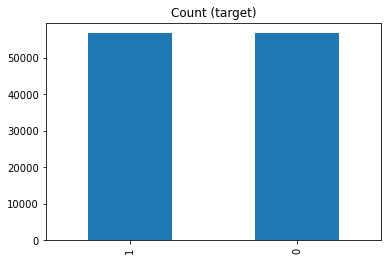

In [41]:
# Class count
count_class_0, count_class_1 = train.acesso.value_counts()

train_class_1_over = train_class_1.sample(count_class_0, replace=True)
dfmodelo_test_over = pd.concat([train_class_0, train_class_1_over], axis=0)

print('Random over-sampling:')
print(dfmodelo_test_over.acesso.value_counts())

dfmodelo_test_over.acesso.value_counts().plot(kind='bar', title='Count (target)');

In [42]:
# split data into X and y
X_train = dfmodelo_test_over.drop(columns=['acesso'])
y_train = dfmodelo_test_over.loc[:,'acesso']
X_test = test.drop(columns=['acesso'])
y_test = test.loc[:,'acesso']
X = dfmodelo.drop(columns=['acesso'])
y = dfmodelo.loc[:,'acesso']

In [43]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)

[0.05146978 0.06286469 0.0567345  0.04523173 0.45575345 0.05449689
 0.04881889 0.04721142 0.04909693 0.07822602 0.05009571]


In [44]:
di = dict(zip(train.columns, model.feature_importances_))
sorted_di = sorted(di.items(), key=operator.itemgetter(1))
print (sorted_di)

[('operadora', 0.045231733), ('compradoronline', 0.04721142), ('genero', 0.048818894), ('vendedoronline', 0.049096934), ('rendaestimada', 0.050095715), ('ddd', 0.05146978), ('idade', 0.05449689), ('valor', 0.0567345), ('data_atraso', 0.06286469), ('utilizacaoweb', 0.07822602), ('qtd_hist_acessos', 0.45575345)]


In [45]:
y_pred = model.predict(X_test)
df_y_pred = model.predict_proba(X_test)
df_y_pred = pd.DataFrame(df_y_pred)

## Curva Roc

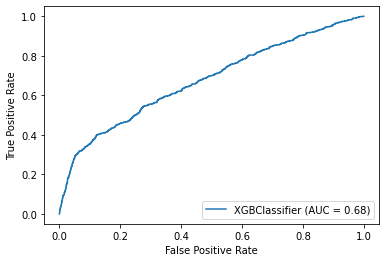

In [46]:
plot_roc_curve(model, X_test, y_test)

## Matriz de confusão desbalanceada

Confusion matrix:
 [[12488  1676]
 [  377   239]]


<ipython-input-47-b9c5a72f4b28>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-47-b9c5a72f4b28>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


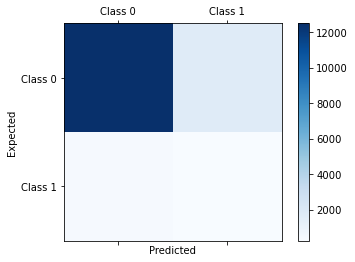

In [47]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

## Matriz de confusão balanceada


Igualamos a proporção de quantidade expected = 0 com expeted = 1

false negative adjusted 8668.551948051949
true negative adjusted 5495.448051948052
[[12488  1676]
 [ 8668  5495]]


<ipython-input-48-a80454fc5115>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-48-a80454fc5115>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


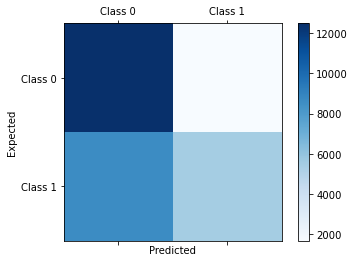

Acurácia: 0.6348136119740186
Recall: 0.3879827720115795
Precisão: 0.7662808534374564


In [48]:
base1 = conf_mat[1].sum()
base2 = conf_mat[0].sum()
print("false negative adjusted",conf_mat[1][0]/base1*base2) 
print("true negative adjusted", conf_mat[1][1]/base1*base2) 

conf_mat2 = conf_mat
conf_mat2[1][0] = conf_mat[1][0]/base1*base2
conf_mat2[1][1] = conf_mat[1][1]/base1*base2

print(conf_mat2)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat2, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

accuracy = (conf_mat2[0][0]+conf_mat2[1][1])/(base2*2)
print('Acurácia:', accuracy)

recall = (conf_mat2[1][1])/(conf_mat2[1][1]+conf_mat2[1][0])
print('Recall:', recall)

precision = (conf_mat2[1][1])/(conf_mat2[1][1]+conf_mat2[0][1])
print('Precisão:', precision)

In [49]:
X = df.drop(columns=['acesso'])
y = df.loc[:,'acesso']

X = X.drop(columns=['id', 'RecebeuSMS', 'acordo'])
X = model.predict_proba(X)

In [50]:
X = pd.DataFrame(X)
X['id'] = df['id'].array
X['acesso'] = y.array
X

,0,1,id,acesso
0,0.937665,0.062335,2,0
1,0.954659,0.045341,21,0
2,0.878786,0.121214,30,0
3,0.735318,0.264682,33,0
4,0.872940,0.127060,44,0
...,...,...,...,...
73894,0.743079,0.256921,686315,0
73895,0.501762,0.498238,686319,0
73896,0.575382,0.424618,686331,0
73897,0.824641,0.175359,686342,0


# Gráficos

<AxesSubplot:>

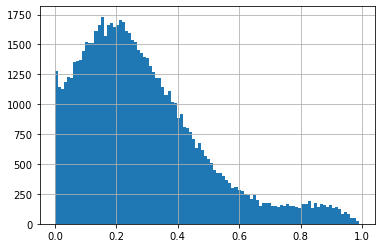

In [51]:
X[1].hist(bins = 100)

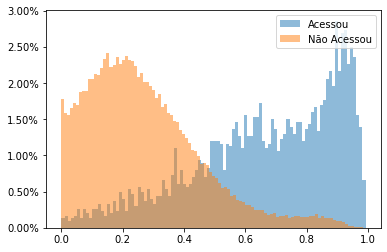

In [52]:
um = X[X["acesso"]==1][1]
zero = X[X["acesso"]==0][1]

plt.hist(um, bins = 100, alpha=0.5, label='Acessou', weights=np.ones(len(um)) / len(um))
plt.hist(zero, bins = 100, alpha=0.5, label='Não Acessou', weights=np.ones(len(zero)) / len(zero))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper right')
plt.show()

acesso
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 1, dtype: object

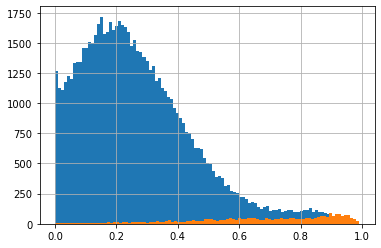

In [53]:
X[1].groupby(X['acesso']).hist(bins=100)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

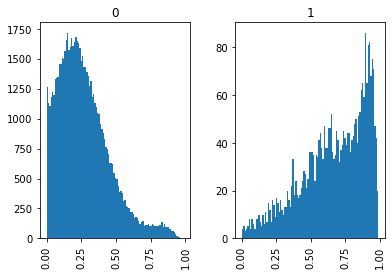

In [54]:
X[1].hist(by=X['acesso'], bins=100)

# Conclusão

- AUC de aproximadamente 0.68
- Acurácia de aproximadamente 0.63
- Recall de aproximadamente 0.39
- Ao observar as métricas, o modelo não está suficiente performático para encontrar os casos verdadeiros positivos (em que a coluna 'acesso' possui valor real 1 e o modelo prediz como 1). 
- O recall, principalmente, possui um valor muito baixo. Estamos classificando como clientes que 'não acessariam' muitos dos que na verdade acessariam;
- Apesar de tudo, com a análise dos gráficos podemos perceber que o modelo gerado condiz com a situação problema. Os valores de probabilidade maiores para prdição 'acesso = 1' se encontram com maior frequência em que casos que o valor real da variável é 1
- A probabilidade dos clientes pode ser exportada abaixo

In [ ]:
X.to_csv(r'modelagem.csv', sep=';', encoding='iso8859-1', index=False)